# Analysis of Steam Games’ Success

## Data processing

Use the same algorithm stole from Shiqi to clean up games that do not have much feedback from users.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import re
plt.style.use('seaborn-deep')

def data_process():
    '''
    Cleaning, transforming the data, adding necessary columns for later analysis
    :return: df: pd.Dataframe
    '''
    import datetime as dt
    
    steamspy_df = pd.read_csv("dataset/steamspy_data.csv")
    steamreq_df = pd.read_csv("dataset/steam_requirements_data.csv")
    steam_df = pd.read_csv("dataset/steam.csv")
    
    #convert price in GBP to USD by merging data from another dataframe
    steamspy_df['initialprice'] = steamspy_df['initialprice']/100
    steamspy_temp = steamspy_df.loc[:, ['appid', 'initialprice']]
    df = pd.merge(steam_df,steamspy_temp,on='appid').drop('price', axis=1)
    steamreq_df = steamreq_df[['steam_appid', 'recommended']]
    steamreq_df.rename(columns={'steam_appid':'appid'}, inplace=True)
    df = pd.merge(df,steamreq_df,on='appid')
    #df.set_index('appid', inplace=True)
    df.rename(columns={'initialprice':'price', 'recommended':'recommended_spec'}, inplace=True)
    assert sum(df['price'].isna())==0
    
    #calculate total ratings and positive rating percentage using postive & negative ratings
    df['total_ratings'] = df['positive_ratings']+df['negative_ratings']
    df['rating_score'] = df['positive_ratings']/df['total_ratings']
    #calculate rating using rating algorithm above
    df['rating'] = df['rating_score']-(df['rating_score']-0.5)*2**(-np.log10(df['total_ratings'] + 1))
    
    #add release_year column
    yr=pd.to_datetime(df['release_date'])
    df['release_year'] = yr.dt.strftime('%Y')
    
    #convert owners interval to midpoint of the interval
    df['owners'] = df['owners'].str.split(pat='-').apply(lambda x: int((int(x[0])+int(x[1]))/2))
    
    #encode popular categories/genres to individual binary columns
    pop_cat = ['Single-player','Multi-player']
    pop_genre = ['Action','Adventure','Casual','FPS','Indie','Racing','RPG','Simulation','Sports','Strategy']
    for cat in pop_cat:
        df[cat] = np.where(df['categories'].str.contains(cat), 1, 0)
        assert df[cat].sum()>0
    for gen in pop_genre:
        if gen=='FPS':
            df[gen] = np.where(df['steamspy_tags'].str.contains(gen), 1, 0)
        else:
            df[gen] = np.where(df['genres'].str.contains(gen), 1, 0)
        assert df[gen].sum()>0

    
    #parse developers and only take first in list
    df['developer']=df['developer'].str.split(pat=';').apply(lambda x: x[0])
    df['publisher']=df['publisher'].str.split(pat=';').apply(lambda x: x[0])
    
    #parse spec info
    def parse_spec(x):
        x = str(x)
        gpu_info = re.search(r'nvidia\s*(geforce)?\s*([gr]t[xs])?\s*[\d\w]+',x, re.IGNORECASE)
        if gpu_info is not None:
            return gpu_info.group()
        return ''
    df['GPU'] = df['recommended_spec'].apply(parse_spec)
    
    return df
    
    
df = data_process()
df.head()

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,...,Adventure,Casual,FPS,Indie,Racing,RPG,Simulation,Sports,Strategy,GPU
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,...,0,0,1,0,0,0,0,0,0,
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,...,0,0,1,0,0,0,0,0,0,
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,...,0,0,1,0,0,0,0,0,0,
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,...,0,0,1,0,0,0,0,0,0,
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,...,0,0,1,0,0,0,0,0,0,


## Comparison of free-to-play and paid video games

### Counts

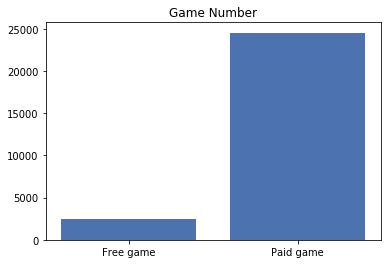

In [2]:
plt.bar(['Free game', 'Paid game'], [len(df[df['price']==0]), len(df[df['price']!=0])])
plt.title('Game Number')
plt.show()

### Top 10 free and paid games by rating

In [3]:
def free_games_by_rating():
    games = df[df['price']==0].sort_values(by='rating', ascending=False)[['name', 'rating', 'owners', 'average_playtime', 'developer', 'release_year', 'genres']]
    games['link'] = df['appid'].apply(lambda x:f'<a href=\'https://store.steampowered.com/app/{x}\'>{x}</a>')
    html = games.head(10).to_html(render_links=True, escape=False)
    display.display_html(html, raw=True)
free_games_by_rating()

,name,rating,owners,average_playtime,developer,release_year,genres,link
16797,Doki Doki Literature Club!,0.953876,3500000,162,Team Salvato,2017,Casual;Free to Play;Indie,698780
7501,Iron Snout,0.953407,1500000,10647,SnoutUp,2016,Action;Free to Play;Indie,424280
3778,Life is Strange - Episode 1,0.949881,7500000,412,DONTNOD Entertainment,2015,Action;Adventure,319630
4924,Eternal Senia,0.948449,750000,15961,Holy Priest,2015,Action;Free to Play;Indie;RPG,351640
3564,The Expendabros,0.946715,3500000,85,Free Lives,2014,Action;Adventure;Free to Play;Indie,312990
4130,Everlasting Summer,0.933255,1500000,249,Soviet Games,2014,Adventure;Casual;Free to Play;Indie,331470
6986,Princess Remedy in a World of Hurt,0.931423,150000,76,Ludosity,2016,Action;Adventure;Indie,407900
19,Team Fortress 2,0.929911,35000000,8495,Valve,2007,Action;Free to Play,440
24,Alien Swarm,0.925437,3500000,371,Valve,2010,Action,630
12461,Cinderella Phenomenon - Otome/Visual Novel,0.922774,150000,1624,Dicesuki,2017,Free to Play;Indie;Simulation,568770


In [4]:
def paid_games_by_rating():
    games = df[df['price']!=0].sort_values(by='rating', ascending=False)[['name', 'rating', 'owners', 'average_playtime', 'developer', 'release_year', 'genres']]
    games['link'] = df['appid'].apply(lambda x:f'<a href=\'https://store.steampowered.com/app/{x}\'>{x}</a>')
    html = games.head(10).to_html(render_links=True, escape=False)
    display.display_html(html, raw=True)
paid_games_by_rating()

,name,rating,owners,average_playtime,developer,release_year,genres,link
23,Portal 2,0.972768,15000000,1102,Valve,2011,Action;Adventure,620
7569,Factorio,0.966302,1500000,10087,Wube Software LTD.,2016,Casual;Indie;Simulation;Strategy;Early Access,427520
2957,The Witcher® 3: Wild Hunt,0.964943,7500000,3068,CD PROJEKT RED,2015,RPG,292030
17,Portal,0.961422,15000000,288,Valve,2007,Action,400
0,Counter-Strike,0.960136,15000000,17612,Valve,2000,Action,10
1115,Terraria,0.959416,7500000,5585,Re-Logic,2011,Action;Adventure;Indie;RPG,105600
1956,The Binding of Isaac: Rebirth,0.959138,3500000,4583,"Nicalis, Inc.",2014,Action,250900
3029,RimWorld,0.958476,1500000,5017,Ludeon Studios,2018,Indie;Simulation;Strategy,294100
21,Left 4 Dead 2,0.956690,15000000,1615,Valve,2009,Action,550
1590,Euro Truck Simulator 2,0.955895,7500000,4942,SCS Software,2012,Indie;Simulation,227300


From the comparison we can see that 7 out of 10 free games are Indie games. 4 of 10 paid games are Indie games. Valve developed 4 of the top 10 paid games. Considering the Steam platform is owned by Valve, it is not a very surprising result.

### Top 10 free and paid games by owners

In [5]:
def free_games_by_owners():
    games = df[df['price']==0].sort_values(by='owners', ascending=False)[['name', 'rating', 'owners', 'average_playtime', 'developer', 'release_year', 'genres']]
    games['link'] = df['appid'].apply(lambda x:f'<a href=\'https://store.steampowered.com/app/{x}\'>{x}</a>')
    html = games.head(10).to_html(render_links=True, escape=False)
    display.display_html(html, raw=True)
free_games_by_owners()

,name,rating,owners,average_playtime,developer,release_year,genres,link
22,Dota 2,0.853115,150000000,23944,Valve,2013,Action;Free to Play;Strategy,570
25,Counter-Strike: Global Offensive,0.863841,75000000,22494,Valve,2012,Action;Free to Play,730
1628,Warframe,0.907931,35000000,5845,Digital Extremes,2013,Action;Free to Play,230410
3355,Unturned,0.894014,35000000,3248,Smartly Dressed Games,2017,Action;Adventure;Casual;Free to Play;Indie,304930
19,Team Fortress 2,0.929911,35000000,8495,Valve,2007,Action;Free to Play,440
14,Half-Life 2: Lost Coast,0.825498,15000000,46,Valve,2005,Action,340
2945,Brawlhalla,0.824011,15000000,724,Blue Mammoth Games,2017,Action;Free to Play;Indie,291550
1601,Heroes & Generals,0.651878,15000000,1752,RETO MOTO,2016,Action;Free to Play;Indie;Massively Multiplayer,227940
1721,War Thunder,0.781990,15000000,4200,Gaijin Entertainment,2013,Action;Free to Play;Massively Multiplayer;Simulation,236390
1766,Path of Exile,0.907081,15000000,5263,Grinding Gear Games,2013,Action;Adventure;Free to Play;Indie;Massively Multiplayer;RPG,238960


In [6]:
def paid_games_by_owners():
    games = df[df['price']!=0].sort_values(by='owners', ascending=False)[['name', 'rating', 'owners', 'average_playtime', 'developer', 'release_year', 'genres']]
    games['link'] = df['appid'].apply(lambda x:f'<a href=\'https://store.steampowered.com/app/{x}\'>{x}</a>')
    html = games.head(10).to_html(render_links=True, escape=False)
    display.display_html(html, raw=True)
paid_games_by_owners()

,name,rating,owners,average_playtime,developer,release_year,genres,link
12827,PLAYERUNKNOWN'S BATTLEGROUNDS,0.504559,75000000,22938,PUBG Corporation,2017,Action;Adventure;Massively Multiplayer,578080
10,Counter-Strike: Source,0.941118,15000000,6842,Valve,2004,Action,240
17,Portal,0.961422,15000000,288,Valve,2007,Action,400
2472,Grand Theft Auto V,0.698591,15000000,9837,Rockstar North,2015,Action;Adventure,271590
21,Left 4 Dead 2,0.956690,15000000,1615,Valve,2009,Action,550
13,Half-Life 2: Deathmatch,0.857412,15000000,311,Valve,2004,Action,320
23,Portal 2,0.972768,15000000,1102,Valve,2011,Action;Adventure,620
1461,PAYDAY 2,0.837914,15000000,3975,OVERKILL - a Starbreeze Studio.,2013,Action;RPG,218620
0,Counter-Strike,0.960136,15000000,17612,Valve,2000,Action,10
7,Counter-Strike: Condition Zero,0.871411,15000000,427,Valve,2004,Action,80


There is almost no game that can be both on rating top 10 and owners top 10. Four exceptions are Team Fortress 2 in free games; CS, L4D2 and HL2 in paid games. All of them are developed by Valve. Most of these games are action games, and only TESV: Skyrim is a RPG. We also noticed that most free games on the table have some kinds of in-game paying mechanism.

### Top 10 free and paid games by average playing time

In [7]:
def free_games_by_ptime():
    games = df[df['price']==0].sort_values(by='average_playtime', ascending=False)[['name', 'rating', 'owners', 'average_playtime', 'developer', 'release_year', 'genres']]
    games['link'] = df['appid'].apply(lambda x:f'<a href=\'https://store.steampowered.com/app/{x}\'>{x}</a>')
    html = games.head(10).to_html(render_links=True, escape=False)
    display.display_html(html, raw=True)
free_games_by_ptime()

,name,rating,owners,average_playtime,developer,release_year,genres,link
9193,The Abbey of Crime Extensum,0.790267,75000,190625,Manuel Pazos,2016,Adventure;Free to Play,474030
1472,The Banner Saga: Factions,0.705842,350000,95245,Stoic,2013,Free to Play;Indie;RPG;Strategy,219340
6007,The Secret of Tremendous Corporation,0.755261,150000,95242,Sebastian Krzyszkowiak,2015,Adventure;Casual;Free to Play;Indie,380140
8961,PRICE,0.911691,350000,63481,YETU GAME,2016,Adventure;Casual;Indie,465520
3962,Shroud of the Avatar: Forsaken Virtues,0.510372,75000,54618,Portalarium,2018,Free to Play;Massively Multiplayer;RPG,326160
12187,The Price of Freedom,0.863308,75000,36029,Construct Studio,2016,Adventure;Indie,561080
22,Dota 2,0.853115,150000000,23944,Valve,2013,Action;Free to Play;Strategy,570
25,Counter-Strike: Global Offensive,0.863841,75000000,22494,Valve,2012,Action;Free to Play,730
2731,Heroine's Quest: The Herald of Ragnarok,0.828139,750000,21247,Crystal Shard,2014,Adventure;Free to Play;Indie;RPG,283880
8788,MANDAGON,0.913784,350000,21233,Blind Sky Studios,2016,Adventure;Free to Play;Indie,461560


In [8]:
def paid_games_by_ptime():
    games = df[df['price']!=0].sort_values(by='average_playtime', ascending=False)[['name', 'rating', 'owners', 'average_playtime', 'developer', 'release_year', 'genres']]
    games['link'] = df['appid'].apply(lambda x:f'<a href=\'https://store.steampowered.com/app/{x}\'>{x}</a>')
    html = games.head(10).to_html(render_links=True, escape=False)
    display.display_html(html, raw=True)
paid_games_by_ptime()

,name,rating,owners,average_playtime,developer,release_year,genres,link
3923,Boundless,0.681562,35000,55204,Wonderstruck,2018,Action;Adventure;Indie;Massively Multiplayer;RPG,324510
2429,X-Plane 11,0.790537,150000,44169,Laminar Research,2017,Simulation,269950
23396,懒人修仙传,0.679974,35000,43632,托更的修罗,2018,Casual;Indie;RPG;Simulation,892420
2017,Fantasy Grounds,0.745031,35000,43074,"SmiteWorks USA, LLC",2014,Indie;RPG;Strategy,252690
8911,Screeps,0.832917,35000,38805,Screeps,2016,Indie;Massively Multiplayer;Strategy,464350
741,FINAL FANTASY XIV Online,0.804005,1500000,28897,Square Enix,2014,Massively Multiplayer;RPG,39210
3796,Darkstone,0.693075,75000,27375,Delphine Software,2014,Action;RPG,320320
15202,Warp Rider,0.407062,35000,25324,Electric Root,2017,Action;Casual;Indie;Racing,656370
16403,Trivia Vault: Science & History Trivia,0.535162,10000,25322,Ripknot Systems,2017,Casual;Indie;Simulation;Strategy,687480
16133,The Moon Night,0.500000,10000,25317,FarBox Games,2017,Action;Adventure;Casual;Indie,680120


We can see that playing time is not correlated to a positive rating or owners. These games themsleves can be time consuming or requires players to put game on background to get some items / golds.

## Relationship between price and game popularity

### Overall Result

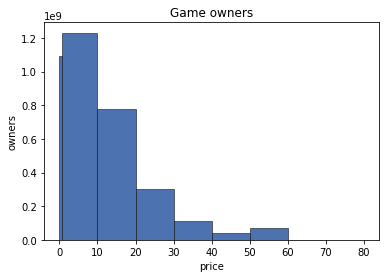

In [9]:
def price_owners():
    priced = df[df['price']<=80]
    plt.hist(priced['price'], bins=[0,0.8]+list(range(10,81,10)), weights=priced['owners'], edgecolor='black', linewidth=0.5)
    plt.title('Game owners')
    plt.xlabel('price')
    plt.ylabel('owners')
    plt.show()
price_owners()

We can see that cheaper games are owned by more people. There is a increase on owners on the range of 50~60 because most 3A titles are launched at price of $59.99.

### By popular genres

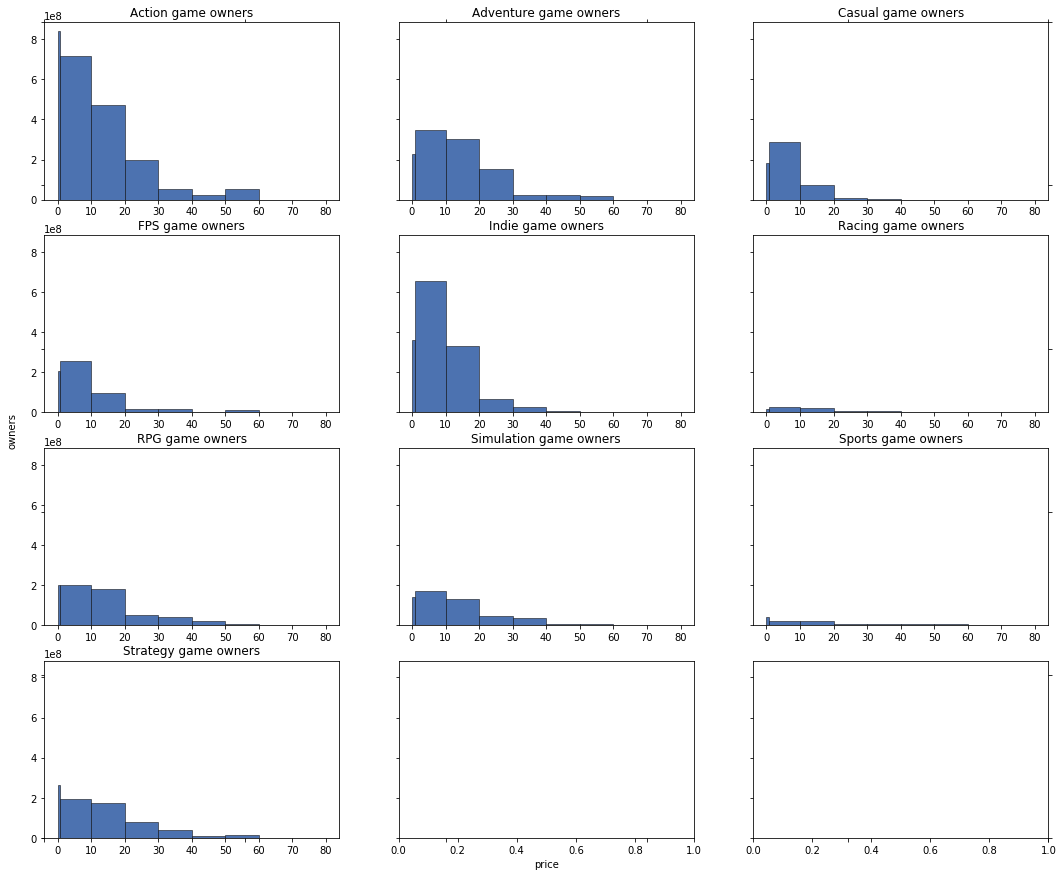

In [10]:
def price_owners_genres():
    pop_genre = ['Action', 'Adventure', 'Casual', 'FPS', 'Indie', 'Racing', 'RPG', 'Simulation', 'Sports', 'Strategy']

    fig, axes = plt.subplots(4, 3, figsize=(18, 15), sharey=True)
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
    plt.grid(False)
    plt.xlabel('price')
    plt.ylabel('owners')

    for genre, subplot in zip(pop_genre, axes.flatten()):
        priced = df[df['price']<=80][df[genre]==1]
        subplot.hist(priced['price'], bins=[0,0.8]+list(range(10,81,10)), weights=priced['owners'], edgecolor='black', linewidth=0.5)
        subplot.title.set_text(f'{genre} game owners')
    plt.show()
price_owners_genres()

To see racing game and sports game more clearly, we also render them as seperate figure:

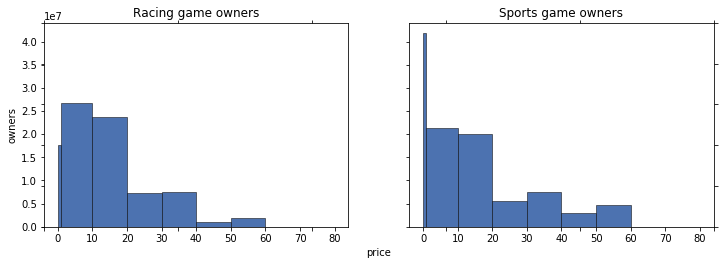

In [11]:
def price_owners_genres_sports_racing():
    pop_genre = ['Racing', 'Sports']
    
    fig, axes = plt.subplots(1 , 2, figsize=(12, 15/4), sharey=True)
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
    plt.grid(False)
    plt.xlabel('price')
    plt.ylabel('owners')

    for genre, subplot in zip(pop_genre, axes.flatten()):
        priced = df[df['price']<=80][df[genre]==1]
        subplot.hist(priced['price'], bins=[0,0.8]+list(range(10,81,10)), weights=priced['owners'], edgecolor='black', linewidth=0.5)
        subplot.title.set_text(f'{genre} game owners')
    plt.show()
price_owners_genres_sports_racing()

Seems that casual games have lower prices and it makes sense. Racing games and sports game are less popular. We can also see that action games and sports games have a lot of free games. For each genre, it is still obvious that cheaper games have more owners. Indie games also have a overall lower price.

## Relationship between system requirements and game popularity

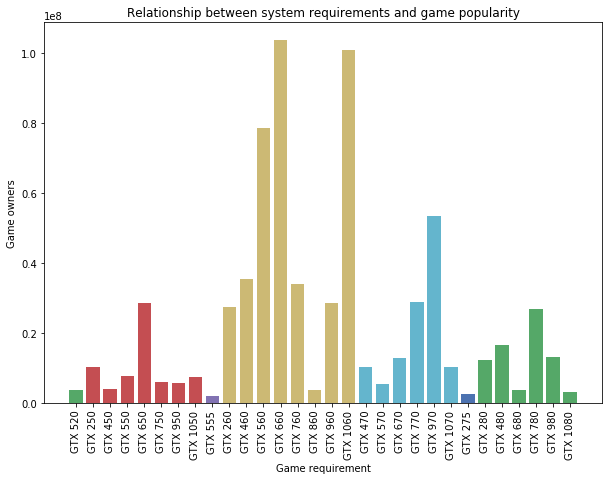

In [14]:
def GPU_relation():
    gpuinfo = df[['owners', 'GPU']][df['GPU']!='']

    gpu_sn = {'': (0,0)}
    def parse_spec(x):
        x = str(x)
        gpu_info = re.search(r'\d+',x, re.IGNORECASE)
        if gpu_info is not None:
            sn = int(gpu_info.group())
            if sn < 100 or sn > 3000: #invalid data
                return ''
            elif sn > 2999: # old nvidia card
                gpu_sn[f'NVIDIA GeForce {sn}'] = (0,0)
                return f'NVIDIA GeForce {sn}'
            else:
                gpu_sn[f'GTX {sn}'] = (sn // 100, sn % 100)
                if sn % 100 == 0:
                    return ''
                return f'GTX {sn}'
        return ''

    gpuinfo['GPU Info'] = gpuinfo['GPU'].apply(parse_spec)
    grouped_info = gpuinfo[gpuinfo['GPU Info']!=''][['GPU Info', 'owners']].groupby('GPU Info').sum().sort_values(by='owners', ascending=False)[:30]
    grouped_info = grouped_info.reset_index()
    grouped_info['sn'] = grouped_info['GPU Info'].apply(lambda x: gpu_sn[x][0])
    grouped_info['sn2'] = grouped_info['GPU Info'].apply(lambda x: gpu_sn[x][1])
    grouped_info = grouped_info.sort_values(by=['sn2', 'sn'])

    colors = ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']
    color_list = []
    color_index = 0
    last_sn = grouped_info['sn2'][0]
    for index, curr_sn in enumerate(grouped_info['sn2']):
        if curr_sn != last_sn:
            color_index = color_index + 1
            last_sn = curr_sn
        if color_index >= len(colors):
            color_index = 0
        color_list.append(colors[color_index])

    plt.figure(figsize=(10,7))
    plt.bar(grouped_info['GPU Info'], grouped_info['owners'],color=color_list)
    plt.xticks(rotation='vertical')
    plt.xlabel('Game requirement')
    plt.ylabel('Game owners')
    plt.title('Relationship between system requirements and game popularity')
    
GPU_relation()

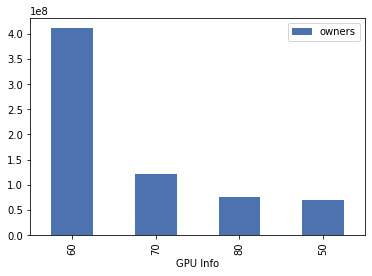

In [15]:
def GPU_relation_byrange():
    gpuinfo = df[['owners', 'GPU']][df['GPU']!='']
    def parse_spec(x):
        x = str(x)
        gpu_info = re.search(r'\d+',x, re.IGNORECASE)
        if gpu_info is not None:
            sn = int(gpu_info.group())
            if sn < 100 or sn > 3000: #invalid data
                return ''
            elif sn > 2999: # old nvidia card
                return ''
            else:
                sn = sn % 100
                if sn == 0:
                    return ''
                return str(sn)
        return ''
    gpuinfo['GPU Info'] = gpuinfo['GPU'].apply(parse_spec)
    gpuinfo[gpuinfo['GPU Info']!=''][['GPU Info', 'owners']].groupby('GPU Info').sum().sort_values(by='owners', ascending=False)[:4].plot.bar()
    plt.savefig('1.png', dpi=300)
    
GPU_relation_byrange()

Since it is hard to process spec info from steam, we only uses about 6000 games' data which can be extracted using Regex. From the bar chart we can see that mid range GPU are gamers' favourite and games require that spec usually sell a lot.